----
# Tutorial for Evaluating Fairness in Regression

----
## Evaluating Your Own Model? Looking for a Template? 
**Please note: This notebook is intended as an introduction to and reference for evaluating the fairness of a set of machine learning models using FairMLHealth, and it is not designed to work with outside models.**  

We recommend using our [Template-RegressionAssessment](../templates/Template-RegressionAssessment.ipynb) if you are looking for a template into which you can insert existing models. 


## Overview

All machine learning models can be assumed to hold biases, just as all humans hold biases and as all humans fall ill at some point in their lives. The motivation that drives us to study and prevent the harm caused by human illness drives us to prevent the harm caused by innate biases. That means building models that provide fair representation for all demographics. This starts with measurement and evaluation.

This notebook introduces concepts, methods, and libraries for measuring fairness in machine learning (ML) models as it relates to problems in healthcare. 

There are abundant other publications covering the theoretical basis for fairness metrics, and many resources both online and academic covering the details of specific fairness measures (See [References (bottom)](#references) and [Additional Resources (bottom)](#additional_resources), or [Our Resources Page](../docs/Measures_QuickReference.md) for just a few). Many of these otherwise excellent references stop short of discussing  edge cases and the practical and philosophical considerations raised when evaluating real models for real customers. Here we attempt to bridge that gap.



## Table of Contents
[Part 1](#part1) - Framing the Problem
  
[Part 2](#part2) - Evaluating the Baseline Model

[Part 3](#part3) - Comparing Models 
  
[References](#references)
  


## Requirements

To run this notebook, please install FairMLHealth using [the instructions posted in GitHub](https://github.com/KenSciResearch/fairMLHealth#installation_instructions). Some components of this notebook additionally require the [Fairlearn](https://github.com/fairlearn/fairlearn) package.

The tutorial uses data from the MIMIC III Critical Care database, a freely accessible source of electronic health records from Beth Israel Deaconess Medical Center in Boston. To download the MIMIC III data, please use this link: [Access to MIMIC III](https://mimic.physionet.org/gettingstarted/access/) and save the data with the default directory name ("MIMIC"). No further action is required beyond remembering the download location, and you do not need to unzip any files.

A basic knowledge of ML implementation in Python is assumed. 


----
---- 
# Part 1 - Framing the Problem <a class = "anchor" id = "part1"></a>

In [1]:
# Standard Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Load Prediction Libraries
import sklearn.metrics as sk_metric
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Remove limit to the number of columns and column widths displayed by pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0) # adjust column width as needed



### Below are helper functions that make the tutorial easier to read

In [2]:
# Helpers from local folder
from fairmlhealth.__mimic_data import load_mimic3_example, feature_table
from fairmlhealth.report import compare
from fairmlhealth import measure, stat_utils


# Verify that all required packages are present
from fairmlhealth.__validation import validate_notebook_requirements
validate_notebook_requirements()

# Functions and pointers to make this tutorial more colorful
ks_magenta = '#d00095'
ks_magenta_lt = '#ff05b8'
ks_purple = '#947fed'


### Loading the MIMIC III Data Subset <a id="datasubset"></a>

As mentioned above, the MIMIC-III data download contains a folder of zipped_files. The tutorial code in the [Data Subset](#datasubset) section below will automatically unzip and format all necessary data for these experiments, saving the formatted data in the same MIMIC folder. Simply enter the correct path of the MIMIC folder in the following cell to enable this feature. Your path should end with the directory "MIMIC".

Example: path_to_mimic_data_folder = "~/data/MIMIC"

In [3]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as Boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [4]:
# Load data and keep a 10K observation subset to speed processing
df = load_mimic3_example(path_to_mimic_data_folder) 
df = df.sample(n=10000, random_state=365).reset_index(drop=True)

# Subset to ages 65+
df = df.loc[df['AGE'].ge(65), :]
df.drop('GENDER_F', axis=1, inplace=True) # Redundant with GENDER_M

# Display insights
display(feature_table(df))
print("\n\n", "Below is a scrollable version of the first five rows of data:")
display(df.head())


 This data subset has 4818 total observations and 648 input features 



,Raw Feature,Category Count (Encoded Features).
0,AGE,1
1,DIAGNOSIS,282
2,ETHNICITY,41
3,GENDER,1
4,INSURANCE,5
5,LANGUAGE,69
6,MARRIED,7
7,PROCEDURE,222
8,RELIGION,20




 Below is a scrollable version of the first five rows of data:


,ADMIT_ID,AGE,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,ETHNICITY_ASIAN - JAPANESE,ETHNICITY_ASIAN - KOREAN,ETHNICITY_ASIAN - OTHER,ETHNICITY_ASIAN - THAI,ETHNICITY_ASIAN - VIETNAMESE,ETHNICITY_BLACK/AFRICAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_BLACK/CAPE VERDEAN,ETHNICITY_BLACK/HAITIAN,ETHNICITY_CARIBBEAN ISLAND,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER),ETHNICITY_HISPANIC/LATINO - COLOMBIAN,ETHNICITY_HISPANIC/LATINO - CUBAN,ETHNICITY_HISPANIC/LATINO - DOMINICAN,ETHNICITY_HISPANIC/LATINO - GUATEMALAN,ETHNICITY_HISPANIC/LATINO - HONDURAN,ETHNICITY_HISPANIC/LATINO - MEXICAN,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_HISPANIC/LATINO - SALVADORAN,ETHNICITY_MIDDLE EASTERN,ETHNICITY_MULTI RACE ETHNICITY,ETHNICITY_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ETHNICITY_OTHER,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN,LANGUAGE_* BE,LANGUAGE_* FU,LANGUAGE_** T,LANGUAGE_**SH,LANGUAGE_**TO,LANGUAGE_*AMH,LANGUAGE_*ARA,LANGUAGE_*ARM,LANGUAGE_*BEN,LANGUAGE_*BOS,LANGUAGE_*BUL,LANGUAGE_*BUR,LANGUAGE_*CAN,LANGUAGE_*CDI,LANGUAGE_*CHI,LANGUAGE_*DEA,LANGUAGE_*DUT,LANGUAGE_*FAR,LANGUAGE_*FIL,LANGUAGE_*FUL,LANGUAGE_*GUJ,LANGUAGE_*HUN,LANGUAGE_*IBO,LANGUAGE_*KHM,LANGUAGE_*LEB,LANGUAGE_*MAN,LANGUAGE_*MOR,LANGUAGE_*NEP,LANGUAGE_*PER,LANGUAGE_*PHI,LANGUAGE_*PUN,LANGUAGE_*SPA,LANGUAGE_*TAM,LANGUAGE_*TOI,LANGUAGE_*TOY,LANGUAGE_*URD,LANGUAGE_*YID,LANGUAGE_*YOR,LANGUAGE_ALBA,LANGUAGE_AMER,LANGUAGE_ARAB,LANGUAGE_BENG,LANGUAGE_CAMB,LANGUAGE_CANT,LANGUAGE_CAPE,LANGUAGE_ENGL,LANGUAGE_ETHI,LANGUAGE_FREN,LANGUAGE_GREE,LANGUAGE_HAIT,LANGUAGE_HIND,LANGUAGE_ITAL,LANGUAGE_JAPA,LANGUAGE_KORE,LANGUAGE_LAOT,LANGUAGE_MAND,LANGUAGE_PERS,LANGUAGE_POLI,LANGUAGE_PORT,LANGUAGE_PTUN,LANGUAGE_RUSS,LANGUAGE_SERB,LANGUAGE_SOMA,LANGUAGE_SPAN,LANGUAGE_TAGA,LANGUAGE_THAI,LANGUAGE_TURK,LANGUAGE_URDU,LANGUAGE_VIET,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARRIED_DIVORCED,MARRIED_LIFE PARTNER,MARRIED_MARRIED,MARRIED_SEPARATED,MARRIED_SINGLE,MARRIED_UNKNOWN (DEFAULT),MARRIED_WIDOWED,RELIGION_7TH DAY ADVENTIST,RELIGION_BAPTIST,RELIGION_BUDDHIST,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,RELIGION_EPISCOPALIAN,RELIGION_GREEK ORTHODOX,RELIGION_HEBREW,RELIGION_HINDU,RELIGION_JEHOVAH'S WITNESS,RELIGION_JEWISH,RELIGION_LUTHERAN,RELIGION_METHODIST,RELIGION_MUSLIM,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE,DIAGNOSIS_CCS_0,DIAGNOSIS_CCS_1,DIAGNOSIS_CCS_2,DIAGNOSIS_CCS_3,DIAGNOSIS_CCS_4,DIAGNOSIS_CCS_5,DIAGNOSIS_CCS_6,DIAGNOSIS_CCS_7,DIAGNOSIS_CCS_8,DIAGNOSIS_CCS_9,DIAGNOSIS_CCS_10,DIAGNOSIS_CCS_11,DIAGNOSIS_CCS_12,DIAGNOSIS_CCS_13,DIAGNOSIS_CCS_14,DIAGNOSIS_CCS_15,DIAGNOSIS_CCS_16,DIAGNOSIS_CCS_17,DIAGNOSIS_CCS_18,DIAGNOSIS_CCS_19,DIAGNOSIS_CCS_20,DIAGNOSIS_CCS_21,DIAGNOSIS_CCS_22,DIAGNOSIS_CCS_23,DIAGNOSIS_CCS_24,DIAGNOSIS_CCS_25,DIAGNOSIS_CCS_26,DIAGNOSIS_CCS_27,DIAGNOSIS_CCS_28,DIAGNOSIS_CCS_29,DIAGNOSIS_CCS_30,DIAGNOSIS_CCS_31,DIAGNOSIS_CCS_32,DIAGNOSIS_CCS_33,DIAGNOSIS_CCS_34,DIAGNOSIS_CCS_35,DIAGNOSIS_CCS_36,DIAGNOSIS_CCS_37,DIAGNOSIS_CCS_38,DIAGNOSIS_CCS_39,DIAGNOSIS_CCS_40,DIAGNOSIS_CCS_41,DIAGNOSIS_CCS_42,DIAGNOSIS_CCS_43,DIAGNOSIS_CCS_44,DIAGNOSIS_CCS_45,DIAGNOSIS_CCS_46,DIAGNOSIS_CCS_47,DIAGNOSIS_CCS_48,DIAGNOSIS_CCS_49,DIAGNOSIS_CCS_50,DIAGNOSIS_CCS_51,DIAGNOSIS_CCS_52,DIAGNOSIS_CCS_53,DIAGNOSIS_CCS_54,DIAGNOSIS_CCS_55,DIAGNOSIS_CCS_56,DIAGNOSIS_CCS_57,DIAGNOSIS_CCS_58,DIAGNOSIS_CCS_59,DIAGNOSIS_CCS_60,DIAGNOSIS_CCS_61,DIAGNOSIS_CCS_62,DIAGNOS

### Generating the Model <a id="generatemodel"></a>


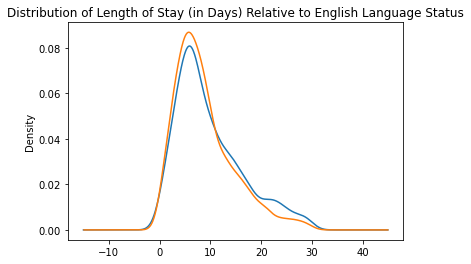

In [5]:
# Display LOS Distributions
ax = df.groupby('LANGUAGE_ENGL')['length_of_stay'
        ].plot(kind='kde', 
               title="Distribution of Length of Stay (in Days) Relative to English Language Status")
plt.show()

In [6]:
# Subset and Split Data
baseline_cols = [c for c in df.columns if (c.startswith('AGE') or c.startswith('DIAGNOSIS_') or c.startswith('PROCEDURE_') or c == "LANGUAGE_ENGL")]
X = df.loc[:, baseline_cols]
y = df['length_of_stay'].clip(0, 25)

#
splits = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = splits

In [7]:
# Train New Model with Language Feature
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
display(np.max(y_pred))


457632780199.59644

In [8]:
# Since the regression is unbounded, clip all values greater than 25 
class bounded_baseline(object):
    def predict(X):
        return np.clip(baseline_model.predict(X), 0, 25)

y_pred = bounded_baseline.predict(X_test)
display(np.max(y_pred))


25.0

### Significance Testing
It's recommended to test for the statistical significance of discrepancies in the distribution of results. This is particularly true for attributes with skewed distributions, for example where the small sample sizes of less common labels may affect fairness measures. However it is still generally recommended to test whether any differences we see relative to our protected attribute are the effect of a sampling error in our test.

FairMLHealth comes with a bootstrapping utility and supporting functions that can be used in statistical testing. While the selection of proper statistical tests is beyond the scope of this notebook, two examples using the bootstrap_significance tool with built-in test functions are shown below.

For this example we detect no statistical difference. We can use these results as evidence in our decision to proceed with the model or continue evaluation. For the sake of this tutorial, we'll continue as if a statistical difference was found.

In [9]:
speaks_engl = df['LANGUAGE_ENGL'].eq(1)

# Krusakal-Wallis (K-W) to test the likelihood of statistcal difference in the mean LOS
# relative to recorded English-speaking ability in the input data
pval = stat_utils.kruskal_pval(a=df.loc[speaks_engl, 'length_of_stay'], b=df.loc[~speaks_engl, 'length_of_stay'])
print("P-Value of single K-W test:", pval)

# Bootstrapped K-W test for the same data
reject_h0 = stat_utils.bootstrap_significance(func=stat_utils.kruskal_pval, 
                                              a=y.loc[speaks_engl], 
                                              b=y.loc[~speaks_engl],
                                              alpha=0.05,
                                              n_trials=100)
print("Was the p-value less than alpha in at least 1-alpha (0.95) proportion of trials?", reject_h0)


P-Value of single K-W test: 0.43192873114484875
Was the p-value less than alpha in at least 1-alpha (0.95) proportion of trials? False


In [10]:
# Bootstrapped K-W Test for true values
test_speaks_engl = X_test['LANGUAGE_ENGL'].eq(1)
reject_h0 = stat_utils.bootstrap_significance(a=y_test.loc[test_speaks_engl], 
                                              b=y_test.loc[~test_speaks_engl],
                                              alpha=0.05,
                                              n_trials=100)
print("Can we reject the hypothesis that targets are from the same distribution?\n", reject_h0)

Can we reject the hypothesis that targets are from the same distribution?
 False


In [11]:
# Bootstrapped K-W Test for predictions
reject_h0 = stat_utils.bootstrap_significance(a=np.ma.masked_array(y_pred, test_speaks_engl), 
                                              b=np.ma.masked_array(y_pred, ~test_speaks_engl),
                                              alpha=0.05,
                                              n_trials=100)
print("Can we reject the hypothesis that prediction results are from the same distribution?\n", reject_h0)

Can we reject the hypothesis that prediction results are from the same distribution?
 False


### FairMLHealth Stratified Data Table

FairMLHealth includes stratified table features to aid in identifying the source of unfairness or other bias. The data table contains basic statistics specific to each feature-value, in addition to relative statistics for the target value. Since the table can be used to evaluate many features at once, it can be a useful option for identifying patterns of bias either alone or in concert with other (e.g., visual methods).

In [12]:
print("FairMLHealth Stratified Data Table")
measure.data(X_test, y_test, features=['LANGUAGE_ENGL'])


FairMLHealth Stratified Data Table


,Feature Name,Feature Value,Obs.,Entropy,Mean length_of_stay,Median length_of_stay,Missing Values,Std. Dev. length_of_stay,Value Prevalence
0,ALL FEATURES,ALL VALUES,1590,NaN,9.2798,7.7042,0,6.2245,1.0000
1,LANGUAGE_ENGL,0,728,0.9949,10.0220,8.1681,0,6.6152,0.4579
2,LANGUAGE_ENGL,1,862,0.9949,8.6529,7.2806,0,5.8046,0.5421


----
----
# Part 2 - Evaluating the Baseline Model <a id="part2"></a>
In this section we will evaluate an array of fairness measures for a single model. For more information on how to interpret these results, see [Evaluating Fairness](docs/Evaluating_Fairness.md) in our documentation. Skip ahead to [Part 3](#part3) for an example comparing multiple models against each other.

Our experiment tests sociodemographic bias as it relates to language. Here we suppose that individuals who speak English may be given preferential treatment in an English-speaking society due to the requirement of using a translator. Language may also be used as a proxy for race, religion, or nationality, which are [explicitly protected attributes](https://www.eeoc.gov/employers/small-business/3-who-protected-employment-discrimination).


In [13]:
print("FairMLHealth Fairness Measure Report: English Language")
compare(X_test, y_test, X_test['LANGUAGE_ENGL'], bounded_baseline, pred_type="regression")


FairMLHealth Fairness Measure Report: English Language


### FairMLHealth Stratified Performance Table



In [14]:
print("FairMLHealth Stratified Performance Table")
measure.performance(X_test, y_test, y_pred, features=['LANGUAGE_ENGL'], pred_type="regression")

FairMLHealth Stratified Performance Table


,Feature Name,Feature Value,Obs.,Mean Target,Mean Prediction,MAE,MSE,Mean Error,Rsqrd,Std. Dev. Error,Std. Dev. Prediction,Std. Dev. Target
0,ALL FEATURES,ALL VALUES,1590.0,9.2798,9.0329,3.5078,22.0209,-0.2469,0.4313,4.6876,4.7158,6.2245
1,LANGUAGE_ENGL,0,728.0,10.0220,9.6325,3.8030,25.7098,-0.3895,0.4117,5.0590,4.4334,6.6152
2,LANGUAGE_ENGL,1,862.0,8.6529,8.5265,3.2585,18.9054,-0.1265,0.4382,4.3487,4.8872,5.8046


### FairMLHealth Stratified Fairness Table

The stratified bias table contains prediction bias measures specific to each feature-value subset. It assumes each feature-value as the "privileged" group relative to all other possible values for the feature. To simplify the table, fairness measures have been reduced to their component parts. For example, measures of Equalized Odds can be determined by combining the True Positive Rate (TPR) Ratios & Differences with False Positive Rate (FPR) Ratios & Differences.

In [15]:
print("FairMLHealth Stratified Fairness Table")

# Custom "fair" ranges may be passed as dictionaries of tuples whose keys are case-insensive measure names
custom_fair_boundaries = {'mean prediction difference':(-1, 1)}

# Note that flag_oor is set to False by default for this feature
measure.bias(X_test, 
             y_test, 
             y_pred, 
             features=['LANGUAGE_ENGL'], 
             pred_type="regression",
             flag_oor=True, 
             custom_ranges=custom_fair_boundaries
            )

FairMLHealth Stratified Fairness Table


,Feature Name,Feature Value,MAE Difference,MAE Ratio,Mean Prediction Difference,Mean Prediction Ratio
0,LANGUAGE_ENGL,0,-0.5445,0.8568,-1.1060,0.8852
1,LANGUAGE_ENGL,1,0.5445,1.1671,1.1060,1.1297


# Special Cases
Analysis by cohorts.

### Hypothetical Example for which Accuracy is Most Important for Mid-Range Values

Patients undergoing a  surgical procedure, the in-surgery times for which are predicted by a machine learning model.

| Predicted Time in Surgery | Intervention |
| - | - |
|0-5 hours | Non-Invasive Pre-Surgical Procedure |
|5-12 hours | Treatment Decision Depends on Predicted Trends in Surgery Time |
| 12+ hours | Invasive Pre-Surgical Procedure |

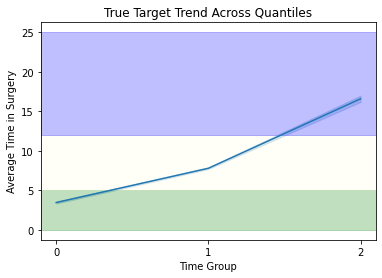

In [16]:
# Generate quantiles
quantiles = pd.qcut(y_test, 3, labels=False).rename('Time Group')

# Generate plots
g = sns.lineplot(x=quantiles, y=y_test)
g.axhspan(0, 5, alpha=0.25, color='green')
g.axhspan(5, 12, alpha=0.25, color='lightyellow')
g.axhspan(12, 25, alpha=0.25, color='blue')
plt.xticks([*range(3)], [*range(3)])
g.set_xlabel("Time Group")
g.set_ylabel("Average Time in Surgery")
g.set_title("True Target Trend Across Quantiles")
plt.show()


In [17]:
measure.bias(X_test, 
             y_test, 
             y_pred, 
             features=['LANGUAGE_ENGL'], 
             pred_type="regression",
             flag_oor=True, 
             custom_ranges=custom_fair_boundaries,
             add_overview=False,
             cohorts=quantiles
            )

,Time Group,Feature Name,Feature Value,MAE Difference,MAE Ratio,Mean Prediction Difference,Mean Prediction Ratio
0,0,LANGUAGE_ENGL,0,-0.8458,0.7490,-1.3085,0.8052
1,0,LANGUAGE_ENGL,1,0.8458,1.3351,1.3085,1.2419
2,1,LANGUAGE_ENGL,0,0.1197,1.0485,-0.4798,0.9446
3,1,LANGUAGE_ENGL,1,-0.1197,0.9537,0.4798,1.0587
4,2,LANGUAGE_ENGL,0,-0.2747,0.9477,0.2406,1.0190
5,2,LANGUAGE_ENGL,1,0.2747,1.0552,-0.2406,0.9813
